<a href="https://colab.research.google.com/github/mong-head/machine_learning/blob/master/NN_AD_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# drive 저장 및 set up

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from pandas import Series, DataFrame

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

import tensorflow as tf
from tensorflow import keras

# * data 처리

Load TADPOLE* dataset (csv file) from Google Drive
-------------------------------------------------------
*The Alzheimer's Disease Prediction Of Longitudinal Evolution
(https://tadpole.grand-challenge.org/)

### -Subjects: 1707 (1363 Train (80%) + 344 Test (20%))
### -Features: 72
*   2 demographic feature: MMSE, ADAS13
*   70 mean values of cortical thickness

데이터 불러오기

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

csv_file_train = '/content/gdrive/My Drive/BNCS401_Midterm_Project/Train_data_reupdated.csv'  # Set your path
train_data = pd.read_csv(csv_file_train)
train_data

# DXCHANGE: clinical label (1-CN, 2-MCI, 3-AD)

Mounted at /content/gdrive


,RID,DXCHANGE,AGE,MMSE,ADAS13,ST102TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST103TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST104TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST105TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST106TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST107TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST108TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST109TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST110TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST111TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST113TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST114TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST115TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST116TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST117TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST118TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST119TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST121TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST123TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST129TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST130TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST13TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST14TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST15TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST23TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST24TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST25TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST26TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST31TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST32TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST34TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST35TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST36TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST38TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST39TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST40TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST43TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST44TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST45TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST46TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST47TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST48TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST49TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST50TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST51TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST52TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST54TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST55TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST56TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST57TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST58TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST59TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST60TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST62TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST72TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST73TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST74TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST82TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST83TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST84TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST85TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST90TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST91TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST93TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST94TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST95TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST97TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST98TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16,ST99TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
0,4084,1,68.4,30,10.00,2.700,2.635,2.613,2.904,2.311,1.647,2.139,2.652,2.604,2.480,3.095,2.144,2.792,2.207,2.903,2.617,4.117,2.701,,3.127,3.051,2.305,2.872,2.732,2.026,3.756,2.813,2.762,2.556,2.916,2.695,2.259,2.690,2.017,2.421,2.949,2.570,2.370,2.674,3.004,2.369,1.599,2.208,2.650,2.739,2.544,3.018,2.377,2.880,2.322,2.657,2.489,3.620,2.711,,2.593,2.792,2.660,1.993,3.734,2.390,2.817,2.471,2.990,2.667,2.490,2.523,2.254,2.171,2.862
1,2196,2,68.2,30,13.00,2.453,2.992,2.470,2.965,2.438,1.584,1.910,2.900,2.451,2.335,2.771,2.354,2.712,2.001,2.729,2.363,3.613,2.475,,3.196,3.334,2.343,2.729,2.627,1.742,3.383,2.647,2.758,2.394,2.634,2.334,2.241,2.824,1.865,2.383,2.866,2.334,2.793,2.413,2.874,2.316,1.478,1.909,2.780,2.589,2.133,3.036,2.329,2.687,2.070,2.783,2.594,3.405,2.367,,2.582,2.977,2.489,1.868,3.220,2.683,2.569,2.372,2.854,2.867,2.233,2.793,1.987,2.428,2.943
2,657,1,77.7,29,15.33,2.249,2.296,2.315,2.681,2.420,1.386,1.830,2.466,2.3

train_data.info()로 확인하니, 빠져있는 데이터도 있고(예측값인 ADAS13, cortical값 중에 1개), 실제로는 NaN값이지만 ' '로 채워진 데이터가 2개가 있었다.

' '로 채워져 있어 object인 두 cortical값
*   ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16
*   ST123TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16

데이터 처리 순서
1. object 처리 : space to NaN
2. imputer : median으로 빠져있는 값들 채우기
3. feature scaling - RobustScaler : cortical, age 값의 범위를 같게 맞춘다.

** StandardScaler안쓰고 RobustScaler하는 이유 : 실제로 이게 더 나았음- outlier제거가 되기때문임

2,3을 pipeline으로 하고, 2 전에 AD_tr(cortical값들, age),y(reg/cls)로 나누고,

AD_tr만 pipeline해서 X로 만들고, y는 imputer만 한다.


1) object처리
---

In [0]:
#2개의 cortical feature가 float이 아니라 object이고, ' '로 채워져있다.
ob1 = train_data["ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16"]
ob2 = train_data["ST123TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16"]
print(len(train_data[ob1.isnull()]), ob1.dtypes)
print(len(train_data[ob2.isnull()]),ob2.dtypes)

0 object
0 object


In [0]:
#그냥 ' '로 뜬다.
train_data["ST64TA_UCSFFSX_11_02_15_UCSFFSX51_08_01_16"][0]

' '

In [0]:
def object_to_float(o): #o = train_data["~~"] 형태
  for i in range(1363):
    if o[i] == ' ':
      o[i] = np.nan #nan으로 채움

In [0]:
object_to_float(ob1)
object_to_float(ob2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
print(len(train_data[ob1.isnull()]), ob1.dtypes)
print(len(train_data[ob2.isnull()]),ob2.dtypes)

724 object
724 object


**train, test set나누기
---
AD_train, AD_test = 

In [0]:
#RID는 버림
train_data = train_data.drop("RID",axis=1)

** trian, test set 나누기
---
train set에서 model들의 train loss와 validation loss등을 보며 model을 결정하고

test set에서 마지막으로 검사해보았을 때에도 최적의 모델이라면 

그 모델을 선택하고, 마지막에는 train, test set 나누기 전의 X로 최종으로 선택했던 모델로 마지막 training시킨다.

In [0]:
from sklearn.model_selection import train_test_split

AD_train, AD_test = train_test_split(train_data,test_size=0.2,random_state= 42)

** AD_tr, y나누고, y에는 imputer
---

RID는 버린다.

In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [0]:
##input 해당
X_prepipeline = train_data.drop("MMSE",axis = 1).drop("ADAS13",axis = 1).drop("DXCHANGE",axis = 1)
X_train_prepipeline = AD_train.drop("MMSE",axis = 1).drop("ADAS13",axis = 1).drop("DXCHANGE",axis = 1)
X_test_prepipeline = AD_test.drop("MMSE",axis = 1).drop("ADAS13",axis = 1).drop("DXCHANGE",axis = 1)

#classification input
X_plus_prepipeline = train_data.drop("DXCHANGE",axis = 1)
X_plus_train_prepipeline = AD_train.drop("DXCHANGE",axis = 1)
X_plus_test_prepipeline = AD_test.drop("DXCHANGE",axis = 1)

##output 해당
AD_label_reg = DataFrame({"MMSE":train_data["MMSE"].copy(),
                         "ADAS13":train_data["ADAS13"].copy()})
AD_label_reg_tr = DataFrame({"MMSE":AD_train["MMSE"].copy(),
                         "ADAS13":AD_train["ADAS13"].copy()})
AD_label_reg_test = DataFrame({"MMSE":AD_test["MMSE"].copy(),
                         "ADAS13":AD_test["ADAS13"].copy()})

imputer.fit(AD_label_reg)
temp = imputer.transform(AD_label_reg)
y_reg = pd.DataFrame(temp, columns=AD_label_reg.columns,
                             index=AD_label_reg.index)

imputer.fit(AD_label_reg_tr)
temp = imputer.transform(AD_label_reg_tr)
y_reg_train = pd.DataFrame(temp, columns=AD_label_reg_tr.columns,
                             index=AD_label_reg_tr.index)
imputer.fit(AD_label_reg_test)
temp = imputer.transform(AD_label_reg_test)
y_reg_test = pd.DataFrame(temp, columns=AD_label_reg_test.columns,
                             index=AD_label_reg_test.index)

y_mmse =  DataFrame({"MMSE":y_reg["MMSE"].copy()})
y_mmse_train = DataFrame({"MMSE":y_reg_train["MMSE"].copy()})
y_mmse_test = DataFrame({"MMSE":y_reg_test["MMSE"].copy()})

y_ada =  DataFrame({"ADAS13":y_reg["ADAS13"].copy()})
y_ada_train = DataFrame({"ADAS13":y_reg_train["ADAS13"].copy()})
y_ada_test = DataFrame({"ADAS13":y_reg_test["ADAS13"].copy()})

y_cls =  DataFrame({"DXCHANGE":train_data["DXCHANGE"]})
y_cls_train = DataFrame({"DXCHANGE":AD_train["DXCHANGE"]})
y_cls_test = DataFrame({"DXCHANGE":AD_test["DXCHANGE"]})

incomplete_rows_before = AD_label_reg_tr[AD_label_reg_tr.isnull().any(axis=1)]#.head()
incomplete_rows_after = y_reg_train[y_reg_train.isnull().any(axis=1)]
print("1. before imputer:\n", incomplete_rows_before)
print("\n2. after imputer : \n", incomplete_rows_after)

1. before imputer:
       MMSE  ADAS13
522     23     NaN
25      21     NaN
1311    18     NaN
999     20     NaN
426     25     NaN
946     29     NaN
431     22     NaN

2. after imputer : 
 Empty DataFrame
Columns: [MMSE, ADAS13]
Index: []


2) pipeline : imputer,RobustScaler
---
* imputer - 빈데이터 채우기
* RobustScaler - 값 범위 같게 만들기, Standard보다는 outlier다루는데 더 괜찮을 거 같아서 이것을 썼다.

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [0]:
#빈데이터 모두 보기
incomplete_rows = X_prepipeline[X_prepipeline.isnull().any(axis=1)]#.head()
print("빈데이터 개수: ",len(incomplete_rows))

빈데이터 개수:  724


In [0]:
data_pipeline = Pipeline([
                     ('imputer',SimpleImputer(strategy="median")),
                     ('rb_scaler',RobustScaler()),
])

In [0]:
X = data_pipeline.fit_transform(X_prepipeline)
X_train = data_pipeline.fit_transform(X_train_prepipeline)
X_test = data_pipeline.fit_transform(X_test_prepipeline)

X_plus = data_pipeline.fit_transform(X_plus_prepipeline)
X_plus_train = data_pipeline.fit_transform(X_plus_train_prepipeline)
X_plus_test = data_pipeline.fit_transform(X_plus_test_prepipeline)

# 1- NN regression

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [0]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

In [0]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[71]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(2,activation= "relu"))

    loss = tf.losses.Huber(delta=1.0)
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss=tf.losses.Huber(delta=1.0), optimizer=optimizer)
    return model

model_reg = keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_model,
                                                      epochs=35)

In [0]:
kfold = KFold(n_splits=5, random_state=42)
scores = cross_val_score(model_reg,X,y_reg.values,
                         scoring="neg_mean_squared_error",
                         cv=kfold)
keras_reg_scores = np.sqrt(-scores).mean()
print('keras_reg validation score(rmse) :', keras_reg_scores)

Train on 1090 samples
Epoch 1/35
1090/1090 [==============================] - 0s 412us/sample - loss: 21.1891
Epoch 2/35
1090/1090 [==============================] - 0s 118us/sample - loss: 21.0180
Epoch 3/35
1090/1090 [==============================] - 0s 94us/sample - loss: 20.7940
Epoch 4/35
1090/1090 [==============================] - 0s 113us/sample - loss: 20.5124
Epoch 5/35
1090/1090 [==============================] - 0s 93us/sample - loss: 20.1310
Epoch 6/35
1090/1090 [==============================] - 0s 92us/sample - loss: 19.6539
Epoch 7/35
1090/1090 [==============================] - 0s 88us/sample - loss: 19.0428
Epoch 8/35
1090/1090 [==============================] - 0s 86us/sample - loss: 18.2766
Epoch 9/35
1090/1090 [==============================] - 0s 95us/sample - loss: 17.3531
Epoch 10/35
1090/1090 [==============================] - 0s 109us/sample - loss: 16.3032
Epoch 11/35
1090/1090 [==============================] - 0s 89us/sample - loss: 15.2096
Epoch 12/35
109

In [0]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3,4,5],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(model_reg, param_distribs, n_iter=10,
                                   cv=3, scoring="neg_mean_squared_error",
                                   verbose=2)
rnd_search_cv.fit(X, y_reg.values, epochs=35,
                  validation_split=0.1,
                  callbacks=[early_stopping_cb])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.00031701627936568455, n_hidden=3, n_neurons=55 ..
Train on 817 samples, validate on 91 samples
Epoch 1/35


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


817/817 [==============================] - 1s 700us/sample - loss: 21.3269 - val_loss: 21.0306
Epoch 2/35
817/817 [==============================] - 0s 142us/sample - loss: 21.3132 - val_loss: 21.0134
Epoch 3/35
817/817 [==============================] - 0s 138us/sample - loss: 21.2986 - val_loss: 20.9956
Epoch 4/35
817/817 [==============================] - 0s 124us/sample - loss: 21.2834 - val_loss: 20.9770
Epoch 5/35
817/817 [==============================] - 0s 120us/sample - loss: 21.2675 - val_loss: 20.9576
Epoch 6/35
817/817 [==============================] - 0s 122us/sample - loss: 21.2508 - val_loss: 20.9374
Epoch 7/35
817/817 [==============================] - 0s 125us/sample - loss: 21.2333 - val_loss: 20.9164
Epoch 8/35
817/817 [==============================] - 0s 126us/sample - loss: 21.2150 - val_loss: 20.8946
Epoch 9/35
817/817 [==============================] - 0s 130us/sample - loss: 21.1958 - val_loss: 20.8720
Epoch 10/35
817/817 [==============================] - 0s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


818/818 [==============================] - 1s 692us/sample - loss: 21.4865 - val_loss: 21.1540
Epoch 2/35
818/818 [==============================] - 0s 124us/sample - loss: 21.4855 - val_loss: 21.1527
Epoch 3/35
818/818 [==============================] - 0s 125us/sample - loss: 21.4844 - val_loss: 21.1513
Epoch 4/35
818/818 [==============================] - 0s 142us/sample - loss: 21.4833 - val_loss: 21.1497
Epoch 5/35
818/818 [==============================] - 0s 126us/sample - loss: 21.4820 - val_loss: 21.1479
Epoch 6/35
818/818 [==============================] - 0s 120us/sample - loss: 21.4806 - val_loss: 21.1461
Epoch 7/35
818/818 [==============================] - 0s 118us/sample - loss: 21.4790 - val_loss: 21.1441
Epoch 8/35
818/818 [==============================] - 0s 127us/sample - loss: 21.4773 - val_loss: 21.1419
Epoch 9/35
818/818 [==============================] - 0s 134us/sample - loss: 21.4755 - val_loss: 21.1395
Epoch 10/35
818/818 [==============================] - 0s

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1226/1226 [==============================] - 1s 426us/sample - loss: 20.9921 - val_loss: 19.8729
Epoch 2/35
1226/1226 [==============================] - 0s 117us/sample - loss: 19.1581 - val_loss: 18.1086
Epoch 3/35
1226/1226 [==============================] - 0s 119us/sample - loss: 17.7727 - val_loss: 17.7140
Epoch 4/35
1226/1226 [==============================] - 0s 111us/sample - loss: 17.0877 - val_loss: 16.2894
Epoch 5/35
1226/1226 [==============================] - 0s 118us/sample - loss: 14.7794 - val_loss: 14.5875
Epoch 6/35
1226/1226 [==============================] - 0s 111us/sample - loss: 13.5202 - val_loss: 13.4342
Epoch 7/35
1226/1226 [==============================] - 0s 120us/sample - loss: 11.8610 - val_loss: 11.1496
Epoch 8/35
1226/1226 [==============================] - 0s 106us/sample - loss: 9.4486 - val_loss: 8.2914
Epoch 9/35
1226/1226 [==============================] - 0s 131us/sample - loss: 7.4805 - val_loss: 7.2193
Epoch 10/35
1226/1226 [====================

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fab028f3208>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7faae6af8860>,
                                        'n_hidden': [0, 1, 2, 3, 4, 5],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_tra

In [0]:
print('best parameter :',rnd_search_cv.best_params_)
print('best score(rmse) :',np.sqrt(-rnd_search_cv.best_score_))
print('best estimator :',rnd_search_cv.best_estimator_)

best parameter : {'learning_rate': 0.015618437282778579, 'n_hidden': 1, 'n_neurons': 72}
best score(rmse) : 5.326996526865439
best estimator : <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7faae6a87c50>


In [0]:
hidden_num = rnd_search_cv.best_params_['n_hidden']
neurons_num =  rnd_search_cv.best_params_['n_neurons']
learning_r = rnd_search_cv.best_params_['learning_rate']
loss = tf.losses.Huber(delta=1.0)
def build_model(n_hidden=hidden_num, n_neurons=neurons_num, learning_rate=learning_r, input_shape=[71]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(2,activation= "relu"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [0]:
model_reg = keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_model
                                                      ,epochs=60)                                                      

In [0]:
kfold = KFold(n_splits=5, random_state=42)
scores = cross_val_score(model_reg,X,y_reg.values,
                         scoring="neg_mean_squared_error",
                         cv=kfold)
keras_reg_scores = np.sqrt(-scores).mean()
print('keras_reg validation score(rmse) :', keras_reg_scores)

Train on 1090 samples
Epoch 1/60
1090/1090 [==============================] - 0s 387us/sample - loss: 19.7490
Epoch 2/60
1090/1090 [==============================] - 0s 91us/sample - loss: 16.1036
Epoch 3/60
1090/1090 [==============================] - 0s 107us/sample - loss: 11.6312
Epoch 4/60
1090/1090 [==============================] - 0s 114us/sample - loss: 9.7305
Epoch 5/60
1090/1090 [==============================] - 0s 96us/sample - loss: 9.0649
Epoch 6/60
1090/1090 [==============================] - 0s 92us/sample - loss: 8.3633
Epoch 7/60
1090/1090 [==============================] - 0s 90us/sample - loss: 7.6374
Epoch 8/60
1090/1090 [==============================] - 0s 91us/sample - loss: 6.8299
Epoch 9/60
1090/1090 [==============================] - 0s 103us/sample - loss: 6.0563
Epoch 10/60
1090/1090 [==============================] - 0s 116us/sample - loss: 5.3164
Epoch 11/60
1090/1090 [==============================] - 0s 98us/sample - loss: 4.6459
Epoch 12/60
1090/1090 

In [0]:
model_reg.fit(X, y_reg.values, epochs=100,
                  validation_split=0.1,
                  callbacks=[early_stopping_cb])

Train on 1226 samples, validate on 137 samples
Epoch 1/100
1226/1226 [==============================] - 1s 413us/sample - loss: 19.9516 - val_loss: 17.2662
Epoch 2/100
1226/1226 [==============================] - 0s 117us/sample - loss: 14.4540 - val_loss: 11.7231
Epoch 3/100
1226/1226 [==============================] - 0s 115us/sample - loss: 10.2448 - val_loss: 10.3893
Epoch 4/100
1226/1226 [==============================] - 0s 116us/sample - loss: 9.2025 - val_loss: 9.7757
Epoch 5/100
1226/1226 [==============================] - 0s 120us/sample - loss: 8.4859 - val_loss: 8.9997
Epoch 6/100
1226/1226 [==============================] - 0s 113us/sample - loss: 7.7038 - val_loss: 8.0203
Epoch 7/100
1226/1226 [==============================] - 0s 111us/sample - loss: 6.8803 - val_loss: 7.0562
Epoch 8/100
1226/1226 [==============================] - 0s 112us/sample - loss: 6.0716 - val_loss: 6.2571
Epoch 9/100
1226/1226 [==============================] - 0s 128us/sample - loss: 5.3375 - v

In [0]:
predict_test = model_reg.predict(X)
print('NN keras predict:\n' ,predict_test)
print('real y: \n',y_reg.values)

NN keras predict:
 [[29.39446    7.2868323]
 [28.675013  12.430223 ]
 [28.01379   15.016221 ]
 ...
 [26.057144  19.790718 ]
 [29.838053  19.374912 ]
 [27.94377   13.519667 ]]
real y: 
 [[30.   10.  ]
 [30.   13.  ]
 [29.   15.33]
 ...
 [26.   27.  ]
 [23.   29.33]
 [30.   12.  ]]


# 중간고사 regression : randomforest

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [1500],  #n_estimators : 생성할 tree개수-많을수록 좋은듯 500,1000,1500
    'max_features': [34],    #max_features : 최대 선택할 특성의 수 34,35,36
    'max_depth' : [15]
     }
  ]

rf_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(rf_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X,y_reg)

print('best estimator : ')
print(grid_search.best_estimator_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best estimator : 
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=34, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1500,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


In [0]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

final_reg = grid_search.best_estimator_

final_reg.fit(X,y_reg)
final_reg = MultiOutputRegressor(final_reg)
final_reg.fit(X,y_reg)

final_reg_predictions = final_reg.predict(X)
final_reg_mse = mean_squared_error(y_reg, final_reg_predictions)
final_reg_rmse = np.sqrt(final_reg_mse)

scores = cross_val_score(final_reg,X,y_reg,
                         scoring="neg_mean_squared_error",cv=5)
final_reg_scores = np.sqrt(-scores).mean()

print("final regression model : randomforest")
print("--------------------------------------")
print("final model train loss : ", final_reg_rmse)
print("final model validation loss: ",final_reg_scores)

final regression model : randomforest
--------------------------------------
final model train loss :  2.0519076740841107
final model validation loss:  5.187938017583692


# 2- NN classification

In [0]:
from keras import metrics

Using TensorFlow backend.


In [0]:
def build_model_clf(n_hidden=1, n_neurons=30, input_shape=[73]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="selu"))
    model.add(keras.layers.Dense(3, activation= "softmax"))

    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer="sgd",
                  metrics=['sparse_categorical_accuracy'])
    return model

model_clf = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model_clf,
                                                      epochs=100)

In [0]:
kfold = KFold(n_splits=5, random_state=42)
scores = cross_val_score(model_clf,X_plus,y_cls.values.T[0],
                         scoring="accuracy",
                         cv=kfold)
print('keras_reg validation score(accuracy) :', scores.mean())

Train on 1090 samples
Epoch 1/100
1090/1090 [==============================] - 0s 410us/sample - loss: 1.3076 - sparse_categorical_accuracy: 0.3872
Epoch 2/100
1090/1090 [==============================] - 0s 110us/sample - loss: 1.0392 - sparse_categorical_accuracy: 0.4761
Epoch 3/100
1090/1090 [==============================] - 0s 115us/sample - loss: 0.9286 - sparse_categorical_accuracy: 0.5495
Epoch 4/100
1090/1090 [==============================] - 0s 124us/sample - loss: 0.8584 - sparse_categorical_accuracy: 0.5716
Epoch 5/100
1090/1090 [==============================] - 0s 121us/sample - loss: 0.8078 - sparse_categorical_accuracy: 0.6028
Epoch 6/100
1090/1090 [==============================] - 0s 110us/sample - loss: 0.7697 - sparse_categorical_accuracy: 0.6248
Epoch 7/100
1090/1090 [==============================] - 0s 111us/sample - loss: 0.7373 - sparse_categorical_accuracy: 0.6422
Epoch 8/100
1090/1090 [==============================] - 0s 109us/sample - loss: 0.7120 - sparse

In [0]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3,4,5],
    "n_neurons": np.arange(1, 100)
}

rnd_search_clf = RandomizedSearchCV(model_clf, param_distribs, n_iter=10,
                                   cv=kfold, scoring='accuracy',
                                   verbose=2)
rnd_search_clf.fit(X_plus, y_cls.values.T[0], epochs=100,
                  validation_split=0.1,
                  callbacks=[early_stopping_cb])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_neurons=86, n_hidden=5 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 981 samples, validate on 109 samples
Epoch 1/100
981/981 [==============================] - 1s 917us/sample - loss: 0.8994 - sparse_categorical_accuracy: 0.5566 - val_loss: 0.7624 - val_sparse_categorical_accuracy: 0.6055
Epoch 2/100
981/981 [==============================] - 0s 182us/sample - loss: 0.6996 - sparse_categorical_accuracy: 0.6585 - val_loss: 0.7094 - val_sparse_categorical_accuracy: 0.6422
Epoch 3/100
981/981 [==============================] - 0s 184us/sample - loss: 0.6125 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.6488 - val_sparse_categorical_accuracy: 0.6606
Epoch 4/100
981/981 [==============================] - 0s 165us/sample - loss: 0.5756 - sparse_categorical_accuracy: 0.7350 - val_loss: 0.6136 - val_sparse_categorical_accuracy: 0.6881
Epoch 5/100
981/981 [==============================] - 0s 167us/sample - loss: 0.5400 - sparse_categorical_accuracy: 0.7554 - val_loss: 0.6758 - val_sparse_categorical_accuracy: 0.6514
Epoch 6/100
981/981 [========

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


Train on 981 samples, validate on 109 samples
Epoch 1/100
981/981 [==============================] - 1s 929us/sample - loss: 1.0192 - sparse_categorical_accuracy: 0.5005 - val_loss: 0.7652 - val_sparse_categorical_accuracy: 0.6422
Epoch 2/100
981/981 [==============================] - 0s 160us/sample - loss: 0.7449 - sparse_categorical_accuracy: 0.6198 - val_loss: 0.6749 - val_sparse_categorical_accuracy: 0.6972
Epoch 3/100
981/981 [==============================] - 0s 155us/sample - loss: 0.6562 - sparse_categorical_accuracy: 0.6779 - val_loss: 0.6582 - val_sparse_categorical_accuracy: 0.6697
Epoch 4/100
981/981 [==============================] - 0s 161us/sample - loss: 0.6007 - sparse_categorical_accuracy: 0.7044 - val_loss: 0.6310 - val_sparse_categorical_accuracy: 0.6789
Epoch 5/100
981/981 [==============================] - 0s 166us/sample - loss: 0.5579 - sparse_categorical_accuracy: 0.7421 - val_loss: 0.5834 - val_sparse_categorical_accuracy: 0.7431
Epoch 6/100
981/981 [========

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.6min finished


1226/1226 [==============================] - 1s 538us/sample - loss: 1.0601 - sparse_categorical_accuracy: 0.4633 - val_loss: 0.9302 - val_sparse_categorical_accuracy: 0.5328
Epoch 2/100
1226/1226 [==============================] - 0s 143us/sample - loss: 0.8638 - sparse_categorical_accuracy: 0.5514 - val_loss: 0.8287 - val_sparse_categorical_accuracy: 0.6131
Epoch 3/100
1226/1226 [==============================] - 0s 148us/sample - loss: 0.7813 - sparse_categorical_accuracy: 0.6101 - val_loss: 0.7825 - val_sparse_categorical_accuracy: 0.6277
Epoch 4/100
1226/1226 [==============================] - 0s 133us/sample - loss: 0.7267 - sparse_categorical_accuracy: 0.6378 - val_loss: 0.7239 - val_sparse_categorical_accuracy: 0.6715
Epoch 5/100
1226/1226 [==============================] - 0s 130us/sample - loss: 0.6880 - sparse_categorical_accuracy: 0.6607 - val_loss: 0.6920 - val_sparse_categorical_accuracy: 0.6715
Epoch 6/100
1226/1226 [==============================] - 0s 138us/sample - lo

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7faacc9157f0>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'n_hidden': [0, 1, 2, 3, 4, 5],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='accura

In [0]:
print('best parameter :',rnd_search_clf.best_params_)
print('best score(accuracy) :',rnd_search_clf.best_score_)
print('best estimator :',rnd_search_clf.best_estimator_)

best parameter : {'n_neurons': 45, 'n_hidden': 2}
best score(accuracy) : 0.719002201027146
best estimator : <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7faabfbb9d68>


In [0]:
hidden_num = rnd_search_clf.best_params_['n_hidden']
neurons_num =  rnd_search_clf.best_params_['n_neurons']

def build_model_clf(n_hidden=hidden_num, n_neurons=neurons_num, input_shape=[73]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="selu"))
    model.add(keras.layers.Dense(3,activation= "softmax"))

    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer="sgd",
                  metrics=['sparse_categorical_accuracy'])
    return model

model_clf = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model_clf,
                                                      epochs=100)

In [0]:
kfold = KFold(n_splits=5, random_state=42)
scores = cross_val_score(model_clf,X_plus,y_cls.values.T[0],
                         scoring="accuracy",
                         cv=kfold)
print('keras_reg validation score(accuracy) :', scores.mean())

Train on 1090 samples
Epoch 1/100
1090/1090 [==============================] - 1s 465us/sample - loss: 1.1951 - sparse_categorical_accuracy: 0.4367
Epoch 2/100
1090/1090 [==============================] - 0s 128us/sample - loss: 0.9360 - sparse_categorical_accuracy: 0.5257
Epoch 3/100
1090/1090 [==============================] - 0s 120us/sample - loss: 0.8350 - sparse_categorical_accuracy: 0.5661
Epoch 4/100
1090/1090 [==============================] - 0s 113us/sample - loss: 0.7744 - sparse_categorical_accuracy: 0.6064
Epoch 5/100
1090/1090 [==============================] - 0s 124us/sample - loss: 0.7305 - sparse_categorical_accuracy: 0.6330
Epoch 6/100
1090/1090 [==============================] - 0s 122us/sample - loss: 0.6938 - sparse_categorical_accuracy: 0.6532
Epoch 7/100
1090/1090 [==============================] - 0s 118us/sample - loss: 0.6640 - sparse_categorical_accuracy: 0.6890
Epoch 8/100
1090/1090 [==============================] - 0s 118us/sample - loss: 0.6402 - sparse

In [0]:
model_clf.fit(X_plus, y_cls.values.T[0], epochs=100,
                  validation_split=0.1,
                  callbacks=[early_stopping_cb])

Train on 1226 samples, validate on 137 samples
Epoch 1/100
1226/1226 [==============================] - 1s 530us/sample - loss: 1.1291 - sparse_categorical_accuracy: 0.4225 - val_loss: 0.9168 - val_sparse_categorical_accuracy: 0.5109
Epoch 2/100
1226/1226 [==============================] - 0s 135us/sample - loss: 0.8673 - sparse_categorical_accuracy: 0.5449 - val_loss: 0.7813 - val_sparse_categorical_accuracy: 0.6204
Epoch 3/100
1226/1226 [==============================] - 0s 138us/sample - loss: 0.7691 - sparse_categorical_accuracy: 0.6036 - val_loss: 0.7265 - val_sparse_categorical_accuracy: 0.6569
Epoch 4/100
1226/1226 [==============================] - 0s 135us/sample - loss: 0.7157 - sparse_categorical_accuracy: 0.6362 - val_loss: 0.6817 - val_sparse_categorical_accuracy: 0.6934
Epoch 5/100
1226/1226 [==============================] - 0s 129us/sample - loss: 0.6790 - sparse_categorical_accuracy: 0.6542 - val_loss: 0.6572 - val_sparse_categorical_accuracy: 0.6934
Epoch 6/100
1226/1

In [0]:
predict_test = model_clf.predict(X_plus)
print('NN keras predict:\n' ,predict_test)
print('real y: \n',y_cls.values.T[0])

NN keras predict:
 [1 2 2 ... 2 3 1]
real y: 
 [1 2 1 ... 3 3 2]


# 중간고사 classification : Randomforest

In [0]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=42).fit(X_plus_train,y_cls_train)

param_grid = {
    'max_features' : ['auto'], # 'sqrt','log2'
    'max_depth' : [15], # 10,20,30,40,50,60,70, 14,16
    'criterion' : ['entropy'], #'gini'
    'min_samples_split' : [3], #2,10  4,5
    'bootstrap' : [False] #True
}

GS_rfc = GridSearchCV(forest_clf,param_grid,
                      cv=3, scoring = "accuracy")
GS_rfc.fit(X_plus,y_cls)
GS_rfc.best_params_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_split': 3}

In [0]:
final_clf = forest_clf = GS_rfc.best_estimator_
print('randomforest classification best score : ',GS_rfc.best_score_)

randomforest classification best score :  0.7241379310344828


# 결과 분석

regression
---

**NN regression**

hidden으로 relu, selu, output으로 relu, softplus를 해보았으나, hidden, output 모두 relu가 rmse가 낮게 나오는 편이었다. 

학습시, loss는 mse와mae를 합친 huber를 사용했고,

cross validation을 할 때, scroing을 rmse를 했다. 

gridsearch로 hidden layer개수,각 layer마다 뉴런개수가 같다고 보고, 뉴런개수, learning rate를 바꿔가며 가장 나은 model을 찾아보았을 때, 밑과 같았다. 



In [0]:
rnd_search_cv.best_estimator_.model.summary()

Model: "sequential_288"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_831 (Dense)            (None, 72)                5184      
_________________________________________________________________
dense_832 (Dense)            (None, 2)                 146       
Total params: 5,330
Trainable params: 5,330
Non-trainable params: 0
_________________________________________________________________


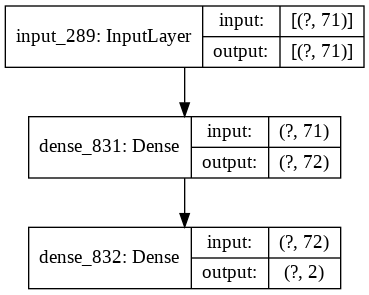

In [0]:
keras.utils.plot_model(rnd_search_cv.best_estimator_.model, show_shapes=True)

NN regression의 cross validation 값

In [0]:
print('keras_reg validation score(rmse) :', keras_reg_scores)

keras_reg validation score(rmse) : 5.391619507108084


In [0]:
#overfitting막기위해 early stopping했을 때의 정확도
print('best score(rmse) :',np.sqrt(-rnd_search_cv.best_score_))

best score(rmse) : 5.326996526865439


RandomForest의 cross validation 값

In [0]:
print("final model train loss : ", final_reg_rmse)
print("final model validation score: ",final_reg_scores)

final model train loss :  2.0519076740841107
final model validation score:  5.187938017583692


중간고사 때 사용한 randomforest의 cross validaion값이 NN와 비교했을 때, 조금 더 좋기는 하지만 큰 차이를 보이지는 않는다.

* 두 예측 값과 실제 값

In [0]:
predict_test = model_reg.predict(X)
print('NN keras predict:\n' ,predict_test)

final_reg_predictions = final_reg.predict(X)
print('random forest predict:\n',final_reg_predictions)

print('real y: \n',y_reg.values)

NN keras predict:
 [[29.39446    7.2868323]
 [28.675013  12.430223 ]
 [28.01379   15.016221 ]
 ...
 [26.057144  19.790718 ]
 [29.838053  19.374912 ]
 [27.94377   13.519667 ]]
random forest predict:
 [[29.29602972  9.72699132]
 [29.24157142 12.16951408]
 [28.46699528 16.24098139]
 ...
 [26.13449512 24.7017786 ]
 [24.01112279 26.87262343]
 [28.9086821  13.62000303]]
real y: 
 [[30.   10.  ]
 [30.   13.  ]
 [29.   15.33]
 ...
 [26.   27.  ]
 [23.   29.33]
 [30.   12.  ]]


classification
---

**NN classification**

hidden은 selu, output layer는 multiclass라서 softmax를 사용했다.
outputlayer는 class개수가 3개이므로 마지막뉴런개수를 3개로하였다.

loss는 label의 형태가 one-hot이아니라 sparse label형태를 가지므로 sparse_categorical_crossetropy를 사용했고, 그에 따라서 accuracy도 sparse_categorical_accuracy를 사용했다.

cross validation을 할 때 scoring은 accuracy를 사용했다.

regression과 마찬가지로, gridsearch를 통해서 hidden layer수와 neuron수를 정하였고, 밑과 같다.

In [0]:
rnd_search_clf.best_estimator_.model.summary()

Model: "sequential_504"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1529 (Dense)           (None, 45)                3330      
_________________________________________________________________
dense_1530 (Dense)           (None, 45)                2070      
_________________________________________________________________
dense_1531 (Dense)           (None, 3)                 138       
Total params: 5,538
Trainable params: 5,538
Non-trainable params: 0
_________________________________________________________________


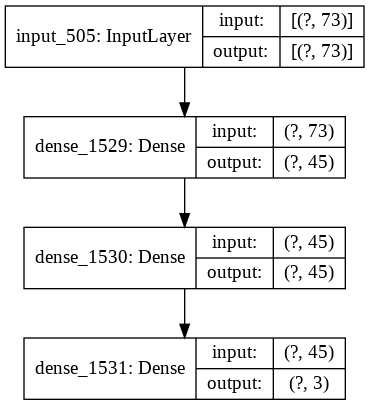

In [0]:
keras.utils.plot_model(rnd_search_clf.best_estimator_.model, show_shapes=True)

NN classification의 cross validation accuracy 값 

In [0]:
print('keras_reg validation score(accuracy) :', scores.mean())

keras_reg validation score(accuracy) : 0.6940530058177117


In [0]:
#gridsearch해서 overfitting하지 않게 early stopping을 했을 때 정확도
print('best score(accuracy) :',rnd_search_clf.best_score_)

best score(accuracy) : 0.719002201027146


randomforest의 cross validation accuracy값

In [0]:
print('randomforest classification best score : ',GS_rfc.best_score_)

randomforest classification best score :  0.7241379310344828


regression과 비슷하게 randomforest값이 NN보다 약간 더 낫지만 그렇게 큰 차이는 보이지 않는다.

* 두 예측값들과 실제값

In [0]:
predict_test = model_clf.predict(X_plus)
print('NN keras predict:\n' ,predict_test)

clf_predictions = final_clf.predict(X_plus)
print('randomforest predict:\n',clf_predictions)

print('real y: \n',y_cls.values.T[0])

NN keras predict:
 [1 2 2 ... 2 3 1]
randomforest predict:
 [1 2 1 ... 3 3 2]
real y: 
 [1 2 1 ... 3 3 2]


**최종 결론**

중간고사 때 선택했던 randomforest가 NN보다 조금 더 나은 cross validation값을 가지지만 큰 차이는 나지 않는다.